# Broadband Tomography with CASTOR

### This notebook implements a forecast for a Broadband Intensity Tomographic Survey with a future all sky UV-optical survey. This is an extension of the measurements reported in https://arxiv.org/abs/1810.00885

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from broadband_tomography_with_castor import *

#### Define Parameter Vector to be Varied 

Initially set to fiducial values

In [3]:
# define fiducial model

nu1500 = speed_of_light/1500
nu1216 = speed_of_light/1216
nu912 = speed_of_light/912


log_e1500z0_b1500z0 = 25.13 #note this degeneracy needs to be resolved 
gammae1500 = 2.06
alpha1500z0 = -0.08
Calpha1500 = 1.85
alpha1100z0 = -3.71
Calpha1100 = 0.50 
EWLyAz03 = -6.17
EWLyAz1 = 88.02
gammabnu = -0.86
gammabz = 0.79

#normalizations

b1500z0 = 0.32 #from "breaking the degeneracy section" --> follow up on this! 
e1500z0 = (10**(log_e1500z0_b1500z0))/b1500z0

#assumed values

alpha900 = -1.5
logfLyCz1 = -0.53 
logfLyCz2 = -0.84 

fLyCz1 = np.exp(logfLyCz1)
fLyCz2 = np.exp(logfLyCz2)

theta =  gammabnu, gammabz, log_e1500z0_b1500z0, gammae1500, alpha1500z0, Calpha1500, alpha1100z0, Calpha1100, EWLyAz1, logfLyCz2, logfLyCz2

## Plot the Parameter Functions in redshift 

Text(0.5, 0, 'z')

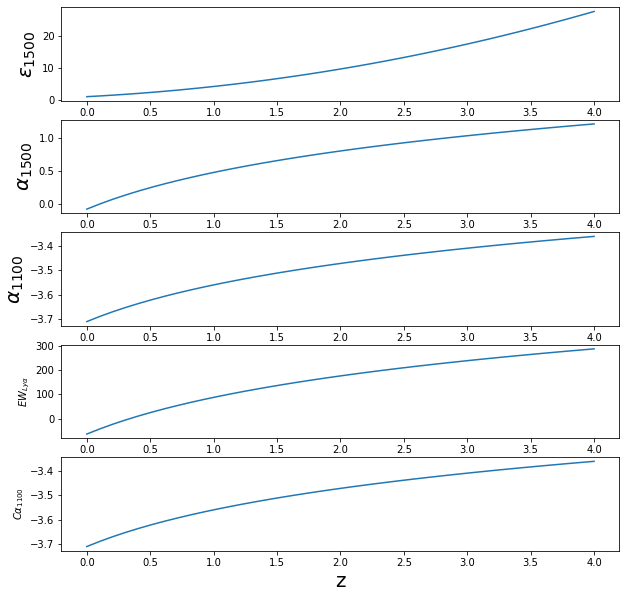

In [4]:
zs1 = np.linspace(0,4,40)

f = plt.figure(figsize=(10,10))

# note missing normalization here, this has been factored out for better comparison 
# with Yi-kuan's results
ax = f.add_subplot(5,1,1)
ax.plot(zs1, e1500_evol(zs1))
ax.set_ylabel(r'$\epsilon_{1500}$', fontsize=20)

ax2 = f.add_subplot(5,1,2)
ax2.plot(zs1, alpha1500(zs1)) 
ax2.set_ylabel(r'$\alpha_{1500}$', fontsize=20)

ax3 = f.add_subplot(5, 1, 3)
ax3.plot(zs1, alpha1100(zs1))
ax3.set_ylabel(r'$\alpha_{1100}$', fontsize=20)

ax4 = f.add_subplot(5,1,4)
ax4.plot(zs1, EWLyA(zs1))
ax4.set_ylabel(r'$EW_{Ly\alpha}$')
ax4.set_xlabel('z', fontsize=20)

ax5 = f.add_subplot(5,1,5)
ax5.plot(zs1, alpha1100(zs1))
ax5.set_ylabel(r'$C\alpha_{1100}}$')
ax5.set_xlabel('z', fontsize=20)

## The bias function
is assumed to be $b(\nu, z) = b^{1500}_{z=0} \big(\frac{\nu}{\nu_{1500}}\big)^{\gamma_{b\nu}}(1+z)^{\gamma_{bz}}$

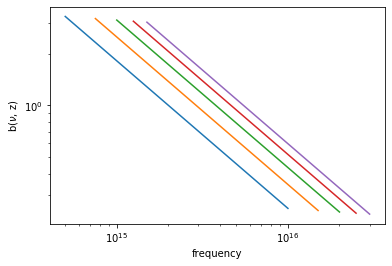

In [5]:
zs = [0.0, 0.5, 1.0, 1.5, 2.0]

obs_waves = np.linspace(300, 6000, 6000-299) #note, this range more than the castor filter set. 

nu_obs = speed_of_light/obs_waves
inverse_nu_obs = 1.0/nu_obs

for z in zs:
    nu = nu_obs * (1+z)
    plt.loglog(nu, b(theta, nu, z))
    plt.xlabel('frequency')
    plt.ylabel(r'b($\nu$, z)')

## Plot the Emissivity Model with CASTOR Wavelength Coverage
Compare with figure 6 of Chiang et al. (2019) but note this includes a parameterization for the optical depth.

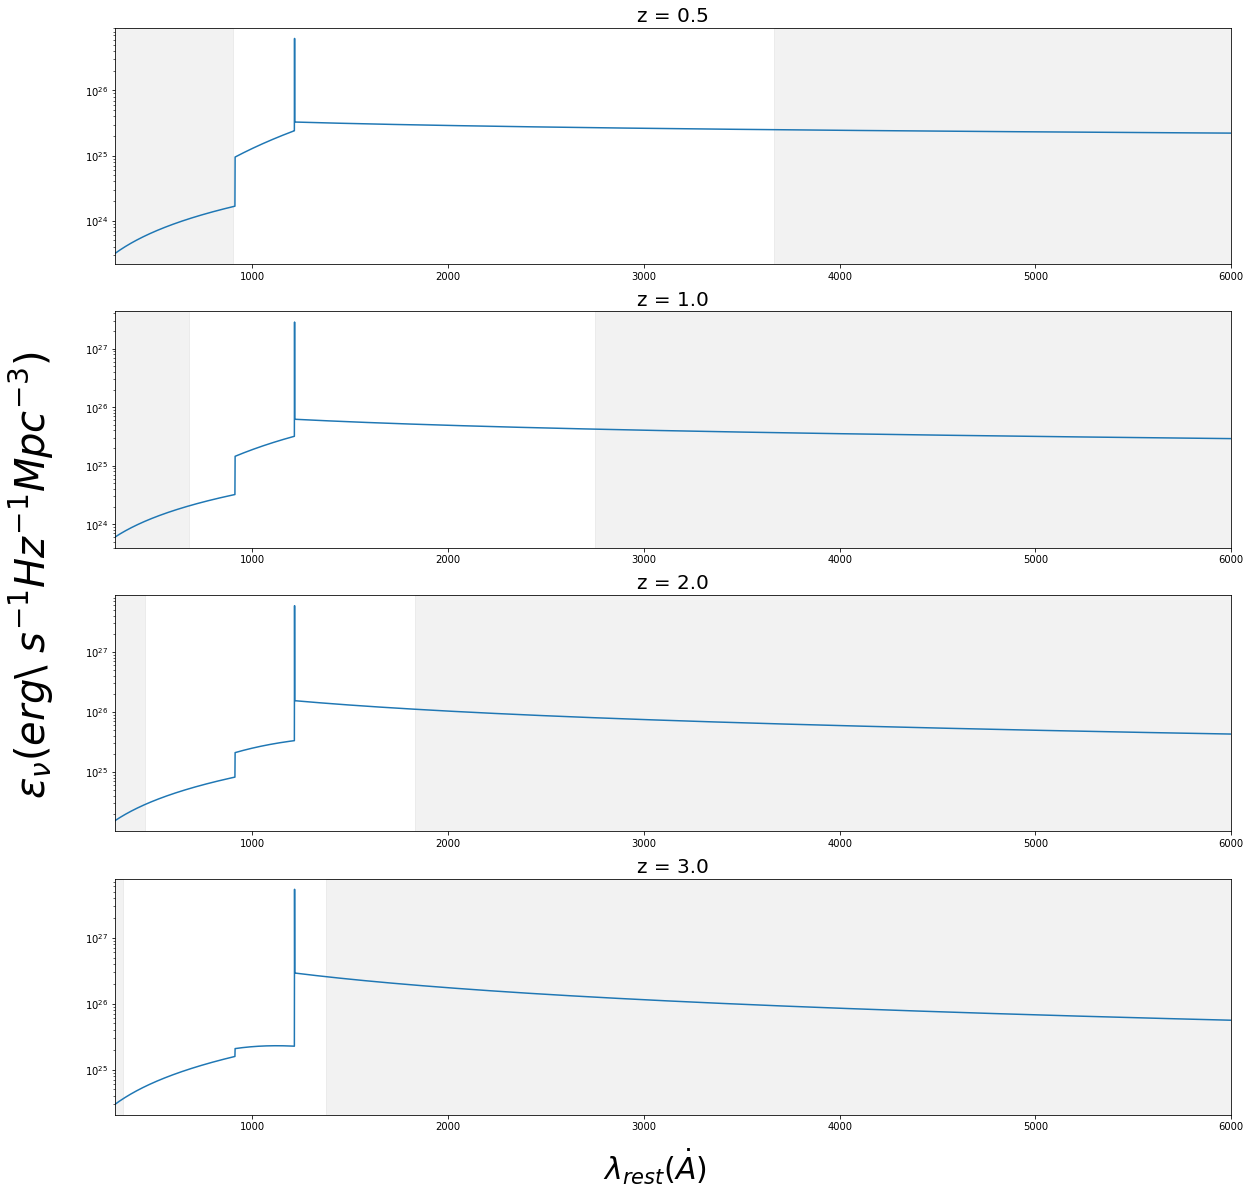

In [6]:
waves = np.linspace(300, 6000, 6000-499)

SED_zs = [0.5, 1, 2, 3]

def redshift(z, lambda_rest): 
    return lambda_rest/(1+z)
        
f = plt.figure(figsize=(20,20))

for i,z in enumerate(SED_zs):
    ax = f.add_subplot(len(SED_zs),1,i+1)
    ax.set_title('z = %1.1f' % SED_zs[i], fontsize = 20)
    ax.set_xlim(300, 6000)
    ax.semilogy(waves, emissivity_model_optical_depth(theta, speed_of_light/waves, z))
    ax.axvspan(redshift(SED_zs[i],300), redshift(SED_zs[i], 1350), color = 'grey', alpha=0.1)
    ax.axvspan(redshift(SED_zs[i], 5500), redshift(SED_zs[i],30000), color = 'grey', alpha=0.1)
    
    
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

    
f.text(0.5, 0.08, r'$\lambda_{rest} (\dot{A})$', ha='center', fontsize=30);
f.text(0.05, 0.5, r'$\epsilon_\nu (erg $\ $ s^{-1} Hz^{-1} Mpc^{-3})$', va='center', rotation='vertical', fontsize=40);

# Radiative Transfer and Forward Model

### The forward model 

Including the bandpass normalization

$\frac{dJ_{\nu_{obs}}}{dz} b_{j}(z) = \frac{1}{\int R(\nu_{obs}) \frac{d\nu_{obs}}{\nu_{obs} }} \frac{c}{4 \pi H(z) (1+z)} \int \frac{d\nu_{obs}}{\nu_{obs}} R(\nu_{obs}) b(\nu_{obs}(1+z), z) \epsilon(\nu_{obs}(1+z), z)$

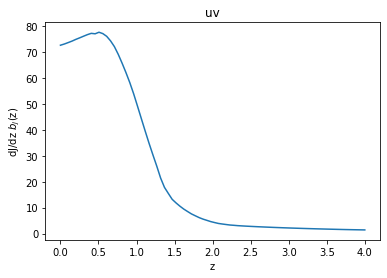

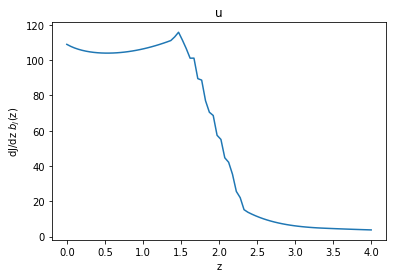

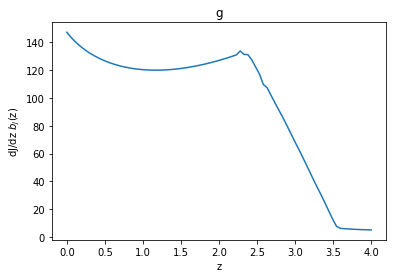

In [7]:
zs = np.linspace(0.0, 4.0, 80)

dJdz_b_uv = np.zeros(len(zs))
dJdz_b_u = np.zeros(len(zs))
dJdz_b_g = np.zeros(len(zs))

for i, z in enumerate(zs):
    dJdz_b_uv[i] = biased_weighted_emissivity(theta, z)[0]
    dJdz_b_u[i] = biased_weighted_emissivity(theta, z)[1]
    dJdz_b_g[i] = biased_weighted_emissivity(theta, z)[2]
    
plt.plot(zs, (dJdz_b_uv))
plt.xlabel('z')
plt.ylabel('dJ/dz $b_j$(z)')
plt.title('uv')
plt.show()

plt.plot(zs, (dJdz_b_u))
plt.xlabel('z')
plt.ylabel('dJ/dz $b_j$(z)')
plt.title('u')
plt.show()

plt.plot(zs, (dJdz_b_g))
plt.xlabel('z')
plt.ylabel('dJ/dz $b_j$(z)')
plt.title('g')
plt.show()

# Full Error Model
Including 
1. photometric zero point that evolves with redshift 
2. Shot Noise contribution
3. Neglected bias evolution

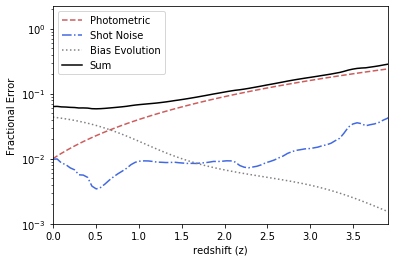

In [21]:
photo_z_line, = plt.semilogy(zs, photo_z_error(0.01, zs), color = 'indianred', linestyle = 'dashed', label = 'Photometric')
shot_z_line, = plt.semilogy(zs, frac_shot_error(), color = 'royalblue', linestyle = '-.', label = 'Shot Noise')
bias_z_line, = plt.semilogy(zs, bias_error(0.5, 0.05, zs), color = 'grey', linestyle =':', label = 'Bias Evolution')
#tot_z_line, = plt.semilogy(zs, tot_frac_error(zs), color = 'black', label = 'Total Fractional')
sum_z_line, = plt.semilogy(zs, photo_z_error(0.01, zs) + frac_shot_error() + bias_error(0.5, 0.05, zs), color = 'black', label = 'Sum')


plt.xlim(0, 3.9)
plt.ylim(1e-3, 2.2)
plt.legend()
plt.xlabel('redshift (z)')
plt.ylabel('Fractional Error')
plt.savefig('updated_error_model.pdf')

# Generate Fiducial Data and Uncertainties from forward model
The Full Error model is shown here.
optimal error model has very small errorbars.

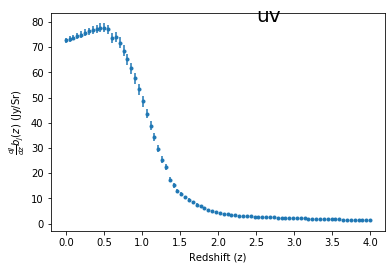

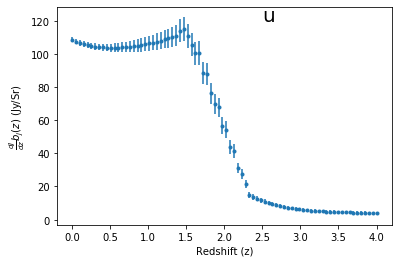

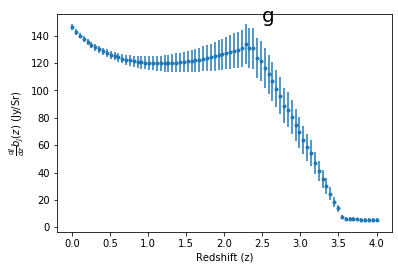

In [15]:
sim_data, error = mk_data(theta, zmin = 0.01, zmax = 4, sample_size = 80, depth = 1, error_model = 2)

plt.errorbar(zs, sim_data[:,0], error[:,0], fmt = '.')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$\frac{dJ}{dz}b_j(z)$ (Jy/Sr)')
plt.text(2.5, 80, 'uv', fontsize='20')
plt.show()

plt.errorbar(zs, sim_data[:,1], error[:,1], fmt = '.')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$\frac{dJ}{dz}b_j(z)$ (Jy/Sr)')
plt.text(2.5, 120, 'u', fontsize='20')
plt.show()


plt.errorbar(zs, sim_data[:,2], error[:,2], fmt = '.')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$\frac{dJ}{dz}b_j(z)$ (Jy/Sr)')
plt.text(2.5, 150, 'g', fontsize='20')
plt.show()